![Logo TUBAF](https://tu-freiberg.de/sites/default/files/media/freiberger-alumni-netzwerk-6127/wbm_orig_rgb_0.jpg)

Exercise material of the MSc-level course **Numerical Methods in Geotechnical Engineering**.
Held at Technische Universität Bergakademie Freiberg.

Comments to:

*Prof. Dr. Thomas Nagel  
Chair of Soil Mechanics and Foundation Engineering  
Geotechnical Institute  
Technische Universität Bergakademie Freiberg.*

https://tu-freiberg.de/en/fakultaet3/gt/soilmechanics


In [23]:
import numpy as np
import matplotlib.pyplot as plt

#Some plot settings
import plot_functions.plot_settings

#FEM routines
%run plot_functions/fem_routines.ipynb

# Liquid-solid phase transition in soils: permafrost melting

## Governing differential equation

We consider the problem as one dimensional with piecewise constant properties:

$$
	\varrho \dot{h} = \lambda T_{,zz}
$$

$[\lambda] = \text{W m^{-1} s^{-1}}$: heat conductivity

$[\varrho] = \text{kg m}^{-3}$: density

$[h] = \text{J kg}^{-1}$: specific enthalpy

Let the ice volume fraction be given as an equilibrium function

$$
    \phi_\text{I} = \phi \left[1 + e^{-k(T - T_\text{m})} \right]^{-1}
$$

so that the apparent ice density is

$$
    \varrho_\text{I} = \phi \varrho_\text{IR} \left[1 + e^{-k(T - T_\text{m})} \right]^{-1}
$$

With $h(T,\varrho_\text{I})$ we then find the energy balance

$$
    \left[ C - L \frac{\partial \varrho_\text{I}}{\partial T} \right] \dot{T} = \lambda T_{,zz}
$$

with 

$[L] = \text{J kg}^{-1}$: specific latent heat of fusion

$[C] = \text{J m}^{-3}$: volumetric heat capacity.

We further use

\begin{align}
    C &= (1 - \phi) c_{p\text{S}} \varrho_\text{SR} + \phi_\text{I} c_{p\text{I}} \varrho_\text{IR} + (\phi - \phi_\text{I}) c_{p\text{W}} \varrho_\text{WR} 
    \\
    \lambda &= (1 - \phi) \lambda_\text{SR} + \phi_\text{I} \lambda_\text{IR} + (\phi - \phi_\text{I}) \lambda_\text{WR} 
\end{align}


## Weak form

The pore pressure can have (the essential/Dirichlet) boundary conditions in the form:

$$
    p = \bar{p}\ \forall z \in \partial \Omega_\mathrm{D}
$$

We now introduce a test function $\eta$ which vanishes where the pore pressure is given

$$
    \eta = 0\ \forall z \in \partial \Omega_\mathrm{D}
$$

and construct the weak form (using integration by parts):

\begin{align}
   0 &= \int \limits_0^H \eta \left[(C - L \partial_T \varrho_\text{I}) \dot{T} - \lambda T_{,zz} \right] \text{d}z
   \\
   &= \int \limits_0^H \left[\eta (C - L \partial_T \varrho_\text{I}) \dot{T} - \left( \eta \lambda T_{,z} \right)_{,z} + \eta_{,z} \lambda T_{,z} \right] \, \text{d}z
   \\
   &= \int \limits_0^H \left[\eta (C - L \partial_T \varrho_\text{I}) \dot{T} + \eta_{,z} \lambda T_{,z} \right] \, \text{d}z + \left[ \eta q_z \right]^H_0
\end{align}

where the natural/Neumann boundary conditions have appeared.

In [24]:
import sympy as sp
k,T,Tm = sp.symbols('k T T_m')
f = 1/(1+sp.exp(k*(T-Tm)))
sp.diff(f,T)

-k*exp(k*(T - T_m))/(exp(k*(T - T_m)) + 1)**2

In [25]:
def phi_I(T,phi=0.35,T_m=273.15):
    return phi / (1 + np.exp(k*(T-(T_m-4/k))))

def dphi_I_dT(T,phi=0.35,T_m=273.15):
    temp = np.exp(k*(T-(T_m-4/k)))
    return -phi*k * temp / (1 + temp)**2

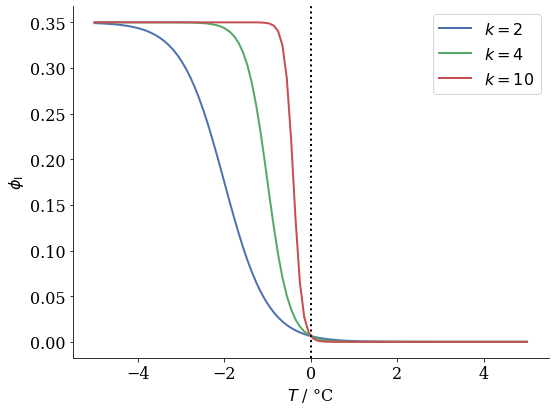

In [26]:
T = np.linspace(-5,5,100)
fig, ax = plt.subplots()
k=2
ax.plot(T,phi_I(T+273.15),label='$k=2$')
k=4
ax.plot(T,phi_I(T+273.15),label='$k=4$')
k=10
ax.plot(T,phi_I(T+273.15),label='$k=10$')
#ax.plot(T,dphi_I_dT(T+273.15),label='$k=10$')
ax.axvline(0,ls=':')
ax.set_xlabel('$T$ / °C')
ax.set_ylabel('$\\phi_\\mathrm{I}$')
ax.legend()
fig.tight_layout();

In [27]:
def heat_capacity(T,phi=0.35,T_m=273.15):
    c_pW = 4186. #J/kgK
    c_pI = 2052. #J/kgK
    c_pS = 500. #J/kgK
    rho_W = 1000. #kg/m³
    rho_I = 900. #kg/m³
    rho_S = 2600. #kg/m³
    L = 334.e3 #J/kg
    phi_ice = phi_I(T,phi,T_m)
    rho_cp = rho_S * (1-phi) * c_pS + rho_W * (phi - phi_ice) * c_pW + rho_I * phi_ice * c_pI
    return rho_cp - dphi_I_dT(T,phi,T_m)*L*rho_I

In [28]:
def heat_conductivity(T,phi=0.35,T_m=273.15):
    lam_W = 0.3 #W/mK
    lam_I = 2.5 #W/mK
    lam_S = 2.2 #W/mK
    phi_ice = phi_I(T,phi,T_m)
    return lam_S * (1-phi) + lam_W * (phi - phi_ice) + lam_I * phi_ice

## Time and space discretization, Picard iterations

Using a backward Euler approach for simplicity we find the time-discrete weak form as ($p_{n+1} \equiv p$)

$$
    0 = \int \limits_0^H \left[\eta (C - L \partial_T \varrho_\text{I}) \frac{T - T_n}{\Delta t} + \eta_{,z} \lambda T_{,z} \right] \, \text{d}z + \left[ \eta q_z \right]^H_0
$$

Introducing standard FE approximations

$$
    T \approx N_i \hat{T}_i, \quad \eta \approx N_i \hat{\eta}_i, \quad \frac{\partial T}{\partial z} \approx \nabla  N_i \hat{T}_i, \quad \frac{\partial \eta}{\partial z} \approx \nabla N_i \hat{\eta}_i
$$

This yields

$$
\begin{align}
 0 &= \int \limits_0^H \left[ N_i \hat{\eta}_i (C - L \partial_T \varrho_\text{I}) \frac{N_k \hat{T}_k - N_k \hat{T}_{n,k}}{\Delta t} + \nabla N_i \hat{\eta}_i \lambda \nabla N_k \hat{T}_k \right] \, \text{d}z + \left[ N_i \hat{\eta}_i q_z \right]^H_0
 \end{align}
$$

Now we bring all quantities associated with the unknown pressure to the left-hand side (LHS) and all known quantities to the RHS:

$$
    \hat{\eta}_i \int \limits_0^H \left[ N_i \frac{(C - L \partial_T \varrho_\text{I})}{\Delta t} N_k + \nabla N_i \lambda \nabla  N_k \right] \, \text{d}z\ \hat{T}_k =  \hat{\eta}_i \left[ N_{n_\text{n}} \bar{q}_z|_{z=H} \delta_{n_\text{n}i} - N_{n_\text{n}} \bar{q}_z|_{z=0} \delta_{i0} \right] +  \hat{\eta}_i \int \limits_0^H N_i \frac{(C - L \partial_T \varrho_\text{I})}{\Delta t} N_k \, \text{d}z\ \hat{T}_{n,k}
$$

can be simplified by realizing that the nodal test function values are arbitrary and thus

$$
    \int \limits_0^H \left[ N_i \frac{(C - L \partial_T \varrho_\text{I})}{\Delta t} N_k + \nabla N_i \lambda \nabla N_k \right] \, \text{d}z\ \hat{T}_k = N_{n_\text{n}} \bar{q}_z|_{z=H} \delta_{n_\text{n}i} - N_{n_\text{n}} \bar{q}_z|_{z=0} \delta_{i0} +  \int \limits_0^H N_i \frac{(C - L \partial_T \varrho_\text{I})}{\Delta t} N_k \, \text{d}z\ \hat{T}_{n,k}
$$

which leaves us with $n_\text{n}$ equations for the $n_\text{n}$ unknown nodal pressures $\hat{p}_k$. If any coefficients in the above are taken as pressure-dependent, the system could be solved repeatedly usind Picard iterations. For strong non-linearities, a Newton linearization would typically be used.

What we require now is the local assembler to calculate the stiffness matrix and the local right-hand side. Local integration is performed by Gauss quadrature:

$$
    \int \limits_{-1}^1 f(\xi)\,\text{d}\xi \approx \sum \limits_{i=1}^{n_\text{gp}} f(\xi_i) w_i 
$$

## Local assember

In [29]:
def local_assembler(elem,dt,prev_sol,sol,mass_lumping=False):
    element_order = elem._line_element__nnodes
    K_loc = np.zeros((element_order,element_order))
    M_loc = np.zeros((element_order,element_order))
    b_loc = np.zeros(element_order)
    z_nodes = elem._line_element__coords
    for i in range(elem._line_element__quad_degree):
        #local integration point coordinate
        xi = elem._line_element__quad_points[i]
        #shape function
        N = shape_function(element_order,xi)
        #gradient of shape function
        dN_dX = grad_shape_function(elem,xi)
        #determinant of Jacobian
        detJ = np.abs(element_jacobian(elem,xi))
        #integration weight
        w = elem._line_element__quad_weights[i]
        
        #global integration point coordinate (for spatially varying properties)
        #z_glob = np.dot(N,z_nodes)
        #evaluation of local material/structural properties
        #E = Stiffness(z_glob)
        #evaluation of local body force
        #CV = ConsolidationCoeff(z_glob)
        
        T_prev = np.dot(N,prev_sol)#T_prev in integration point
        T = np.dot(N,sol)#T in integration point
        
        C = heat_capacity(T)
        lam = heat_conductivity(T)
        #assembly of local stiffness matrix
        M_loc = np.outer(N,N) * C / dt
        if (mass_lumping):
            M_loc = np.diag(M_loc.sum(0)) #diagonal of column sum
           
        K_loc += (np.outer(dN_dX,dN_dX) * lam + M_loc)* w * detJ
        
        #assembly of local RHS
        b_loc += N * C * T_prev/dt * w * detJ
    return K_loc,b_loc

## Time loop and problem solution

We now establish the time loop and in each time step perform the global assembly, apply a vanishing traction on the top and constrain the displacement at the bottom to zero.

In [30]:
def time_loop(dt,nodes,elements,solution,mass_lumping=False):
    #Startwerte
    t_end = 366*24*60*60 * 500#s
    absolute_tolerance = 1.e-6
    max_iter = 100
    iteration_counter = np.array([0])
    apply_initial_conditions(solution,268.15)
    y = [solution] #create a list that will hold the solution vectors at all time points
    times = np.array([0.])
    #
    while times[-1]+dt < t_end: #repeat the loop as long as the final time step is below the end point
        times = np.append(times,times[-1]+dt) #here define the next time point as the previous time point plus the time increment dt
        y_old = y[-1] #Starting value for recursive update
        i = 0
        #
        while True:
            K, f = global_assembler(nodes,elements,y[-1],y_old,dt,mass_lumping)
            #heat flux bc
            f = apply_Neumann_bc(f,0,0.2)
            #alternative: variable surface temperature
            #value = 278.
            #if (times[-1] > 366*24*60*60*300):
            #    value = 268.
            #K, f = apply_Dirichlet_bc(K, f, 0, value)#fixed temperature top
            solution = np.linalg.solve(K,f)
            i += 1
            if (np.abs(np.linalg.norm(solution) - np.linalg.norm(y_old)) < absolute_tolerance or i > max_iter): #if change is below tolerance, stop iterations
                break
            y_old = solution #preparation of next recursion

        y.append(solution) #append the new found solution to the solution vector
        iteration_counter = np.append(iteration_counter,i) #store how much iterations this time step took to converge
    return times, y,iteration_counter

In [31]:
#spatial discretization
H = 150.
nel = 20
n_per_el = 3
nodes,elements,solution=generate_mesh(H,nel,n_per_el)
k = 4

In [32]:
times, sols, iters = time_loop(24*60*60*365,nodes,elements,solution)

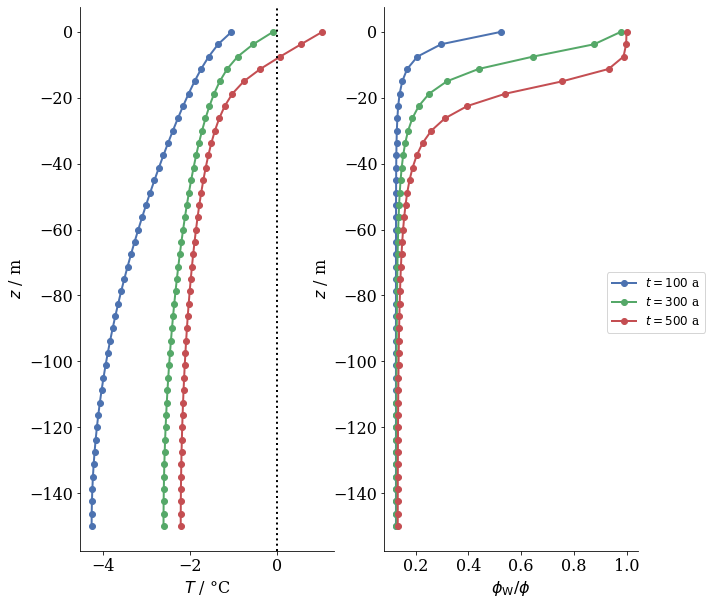

In [34]:
fig, ax = plt.subplots(ncols=2,figsize=(10,10))
ax[0].set_ylabel('$z$ / m')
ax[0].set_xlabel('$T$ / °C')
ax[0].plot(sols[100]-273.15, -nodes, marker='o', label='$t = %i$ a' %(times[100]/60/60/24/365))
ax[0].plot(sols[300]-273.15, -nodes, marker='o', label='$t = %i$ a' %(times[300]/60/60/24/365))
ax[0].plot(sols[500]-273.15, -nodes, marker='o', label='$t = %i$ a' %(times[500]/60/60/24/365))
ax[0].axvline(0,ls=':')

ax[1].set_ylabel('$z$ / m')
ax[1].set_xlabel('$\\phi_\\mathrm{W} / \\phi$')
ax[1].plot((0.4-phi_I(sols[100]))/0.4, -nodes, marker='o')
ax[1].plot((0.4-phi_I(sols[300]))/0.4, -nodes, marker='o')
ax[1].plot((0.4-phi_I(sols[500]))/0.4, -nodes, marker='o')
fig.legend(loc='center right',fontsize=12);